# 2. Models in Gemlib

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gem-epidemics/practical-epidemics/blob/master/site/source/iddinf/02-intro-to-gemlib.ipynb)

**Date**: Monday Sept 9, 2024

This notebook demonstrates `gemlib`, a library for implementing infectious disease models.  It presents unified framework for expressing and simulating models, as well as automatic generation of probability functions used for parameter inference.

__Documentation__: https://gem-epidemics.gitlab.io/gemlib

We first define, in mathematics, a simple model that describes an SEIR epidemic unfolding between 3 connected metapopulations.  We then pass this definition to each of the deterministic, and continuous- and discrete-time stochastic solvers.

In [ ]:
!pip install -Uq gemlib

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import tensorflow as tf
import gemlib

gld = gemlib.distributions

%matplotlib inline

## The state-transition model

We define our population as a composition of 3 distinct units (sub-populations) in which individuals are classified into susceptible, exposed, infected, and removed compartments -- S, E, I, and R respectively.

We use the notation $x^{q}_{it}$ to represent the number of individuals present in compartment $q \in \{\mathrm{S}, \mathrm{E}, \mathrm{I}, \mathrm{R}\}$ in unit $i = \{1,\dots,N\}$ at time $t=\{1,\dots,T\}$.

For convenience, where we drop an index we imply an aggregation over all values of that index.  For example, we denote the _state_ of  unit (i.e. the configuration of S, E, I, and R) at time $t$ as $\mathbf{x}_t$.

We assume that given an initial state, individuals progress sequentially through these compartments according to state-dependent transition rates, which we denote by $\lambda^{qr}_i(\mathbf{x}_t)$ representing the transition rate from state $q$ to state $r$ for unit $i$ at time $t$.

For our intended model, we assume

$$
\begin{align}
\lambda^{\mathrm{SE}}_i(\mathbf{x}_t) & = \frac{\beta \left[ x_{it}^{\mathrm{I}} + \psi C \cdot \left( \frac{\mathbf{x}_t^{\mathrm{I}}}{\mathbf{n}} \right)\right]}{\mathbf{n}} \\
\lambda^{\mathrm{EI}}_i(\mathbf{x}_t) & = \nu \\
\lambda^{\mathrm{IR}}_i(\mathbf{x}_t) & = \gamma \\
\end{align}
$$

where

$$
C = \left(\begin{array}{ccc}
    0 & 0.5 & 0.25 \\
    0.5 & 0 & 0.1 \\
    0.25 & 0.1 & 0
    \end{array}\right)
$$

is a zero-diagonal connectivity matrix between units, $\mathbf{n}$ is a vector of population sizes in each unit, and $\theta = \{\beta, \phi, \nu, \gamma\}$ are parameters to be estimated.


### Defining the connectivity matrix $C$

Here we define an arbitrary connectivity matrix.  For simplicity this matrix is assumed to be symmetric, though in the real world could have an arbitrary structure.

In [ ]:
connectivity = np.array(
    [
        [0.0 , 0.5, 0.25],
        [0.5 , 0.0, 0.1 ],
        [0.25, 0.1, 0.0 ]
    ],
    dtype=np.float32
)

### Defining the state transition model

We begin by defining a graph incidence matrix, where rows represent our 4 states (S, E, I, R), and columns represent the transitions $[SE]$, $[EI]$, and $[IR]$.  Each column gives the increment in the states appropriate for a _single individual_ undergoing the respective transition.

In [ ]:
incidence_matrix = np.array(
    [
        [-1,  0,  0],
        [ 1, -1,  0],
        [ 0,  1, -1],
        [ 0,  0,  1],
    ],
    dtype=np.float32
)

### Defining the state

We define the population state as a collection of SEIR epidemic models:

In [ ]:
initial_state = np.array(
    [  # S    E  I  R
        [99 , 0, 1, 0],  # n=0
        [100, 0, 0, 0],  # n=1
        [100, 0, 0, 0],  # n=2
    ],
    np.float32
)

### Defining the transition rate function

The transition rate function maps a tuple of (time, state) onto a triple of transition rates $\lambda^{qr}_i(t)$ for $i=0, 1, 2$ (remember Python counts from 0).  

As a stylistic manoeuvre, we wrap this function in a "builder" to close over the values of the parameters:

In [ ]:
def make_transition_rate_fn(beta, psi, nu, gamma):
    def trf(t, state):

        within = state[:, 2]  # states are enumerated S, E, I, R from 0
        between = psi * tf.linalg.matvec(
            connectivity, state[:, 2]/tf.reduce_sum(state, axis=-1)
        )
        si_rate = beta * (within + between)
        ei_rate = tf.broadcast_to(nu, si_rate.shape)
        ir_rate = tf.broadcast_to(gamma, si_rate.shape)

        return si_rate, ei_rate, ir_rate
    return trf

## Deterministic solver

The `DeterministicStateTransitionModel` class implements the above model as a system of ODEs.  Under the hood, our ODE solver needs a list of times at which to output the solution of the ODE system, but for consistency with the other solvers (continuous- and discrete-time stochastic) we can provide an initial time, time interval (`time_delta`) between solution times, and the number of solution times we want (`num_steps`).

In [ ]:
det_model = gld.DeterministicStateTransitionModel(
    transition_rate_fn=make_transition_rate_fn(0.02, 0.6, 0.5, 0.2),
    incidence_matrix=incidence_matrix,
    initial_state=initial_state,
    num_steps=100,
    initial_time=1.0,
    time_delta=1.0,
)

To solve the system of ODEs for the state $\mathbf{x}$, we call the `sample()` method.  (Note we wrap the call to `model.sample()` in `tf.function` to invoke TensorFlow graph mode for lightning speed.)

In [ ]:
det_sim = tf.function(lambda: det_model.sample())()

and then plot the state at time $t$ for each subpopulation (we'll make a helper function to avoid code duplication further on down in the notebook):

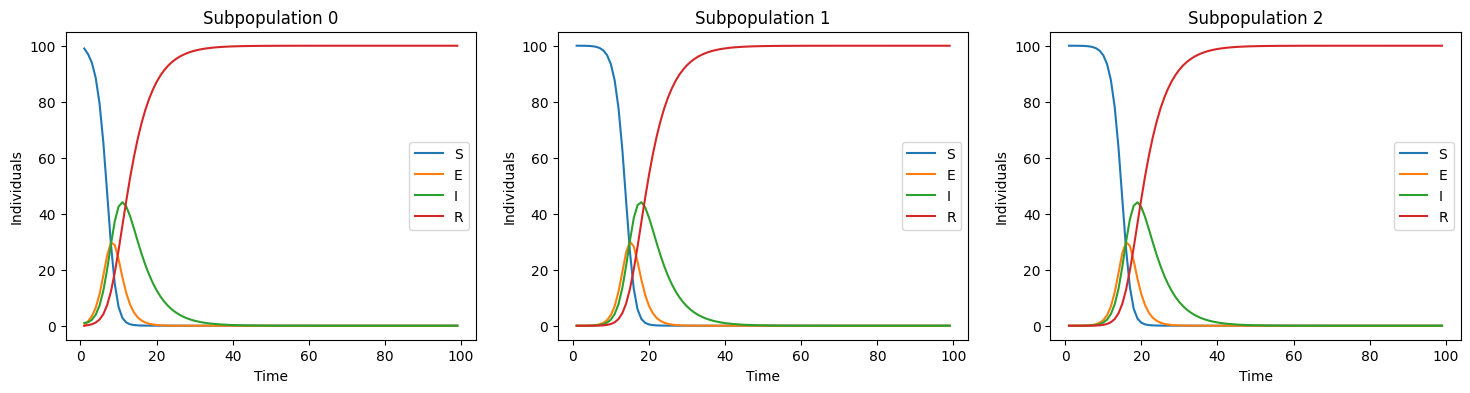

In [ ]:
def plot_timeseries(
        times, states, plot_height=4, labels=["S", "E", "I", "R"], alpha=1.0
):
    num_plots = states.shape[-2]
    fig, ax = plt.subplots(
        1, num_plots, figsize=(num_plots*plot_height*1.5, plot_height)
    )
    for i in range(num_plots):
        for s, label in enumerate(labels):
            state = np.transpose(states[..., i, s])
            ax[i].plot(
                np.transpose(times),
                state,
                label=label,
                color=f"C{s}",
                alpha=alpha
            )
        ax[i].set_title("Subpopulation {}".format(i))
        ax[i].set_xlabel("Time")
        ax[i].set_ylabel("Individuals")
        leg_lines = [Line2D([0], [0], color=f"C{i}") for i in range(len(labels))]
        ax[i].legend(leg_lines, labels)

    return fig, ax

_ = plot_timeseries(det_sim.times, det_sim.states)

## Continuous-time stochastic solver

The continuous-time solver implements the model as a continuous-time Markov-jump process.  Waiting times between transition events are Exponentially-distributed according to a piecewise-constant hazard rate, with the whole model implemented using a [Gillespie algorithm](https://en.wikipedia.org/wiki/Gillespie_algorithm).

In [ ]:
cont_stoch_model = gld.ContinuousTimeStateTransitionModel(
    transition_rate_fn=make_transition_rate_fn(0.02, 0.6, 0.5, 0.2),
    incidence_matrix=incidence_matrix,
    initial_state=initial_state,
    num_steps=1200,
)

In [ ]:
cont_stoch_events = tf.function(lambda: cont_stoch_model.sample(100, seed=[0,1]))()

Unlike the deterministic model, the continuous-time stochastic model outputs an event list, i.e. a list of which transition event happened in which unit (subpopulation) when.  The `cont_stoch_events` data structure has members `time`, `unit`, and `transition`.  Fortunately, `cont_stoch_model` has a method that will reconstruct the state given the event list.

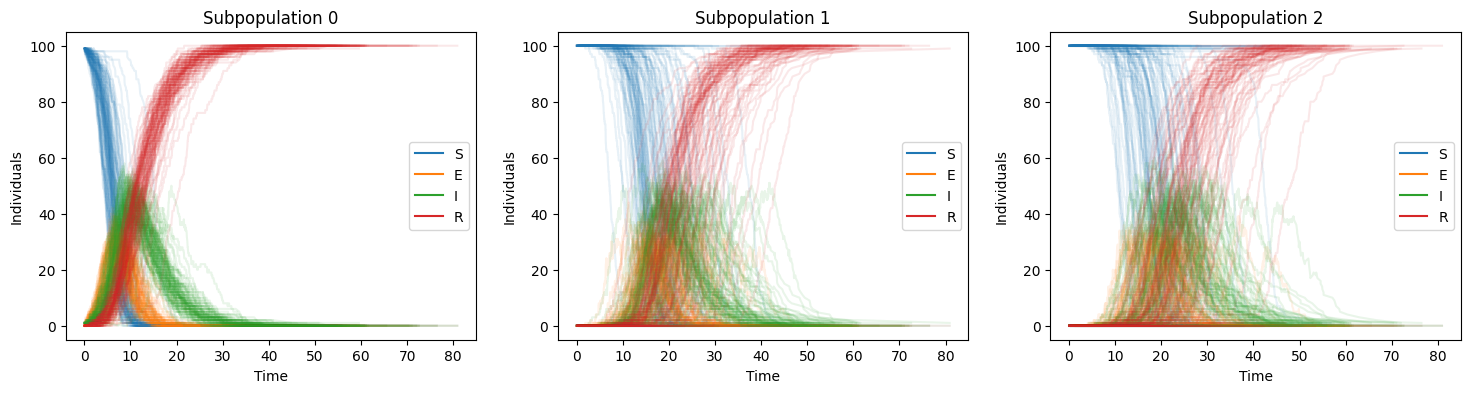

In [ ]:
cont_stoch_states = cont_stoch_model.compute_state(cont_stoch_events)
_ = plot_timeseries(cont_stoch_events.time, cont_stoch_states, alpha=0.1)

## Discrete-time stochastic solver

In the discrete-time model, we take an Euler-Maruyama approach where we propagate the population state forward in discrete time-steps.  To do this, we use a [Markov Cohort State-transition process](https://journals.sagepub.com/doi/10.1177/0272989X221112420?icid=int.sj-abstract.citing-articles.20), which for our SIR model is equivalent to the [chain-binomial model](https://www.jstor.org/stable/2530415).

In [ ]:
disc_stoch_model = gld.DiscreteTimeStateTransitionModel(
    transition_rate_fn=make_transition_rate_fn(0.02, 0.6, 0.5, 0.2),
    incidence_matrix=incidence_matrix,
    initial_state=initial_state,
    num_steps=80,
)

In [ ]:
disc_stoch_events = tf.function(lambda: disc_stoch_model.sample(sample_shape=100, seed=[0,0]))()

As with the continuous-time setup, the discrete-time model simulates an event timeseries, this time as a `[B, T, N, R]`-shaped tensor where `B` is the number of simulations (`sample_shape`), `T` is the number of timesteps, `N` is the number of units, and `R` is the number of transitions (edges) in the state transition model.  As previously, we invoke the `compute_state` method to reconstruct the state timeseries.

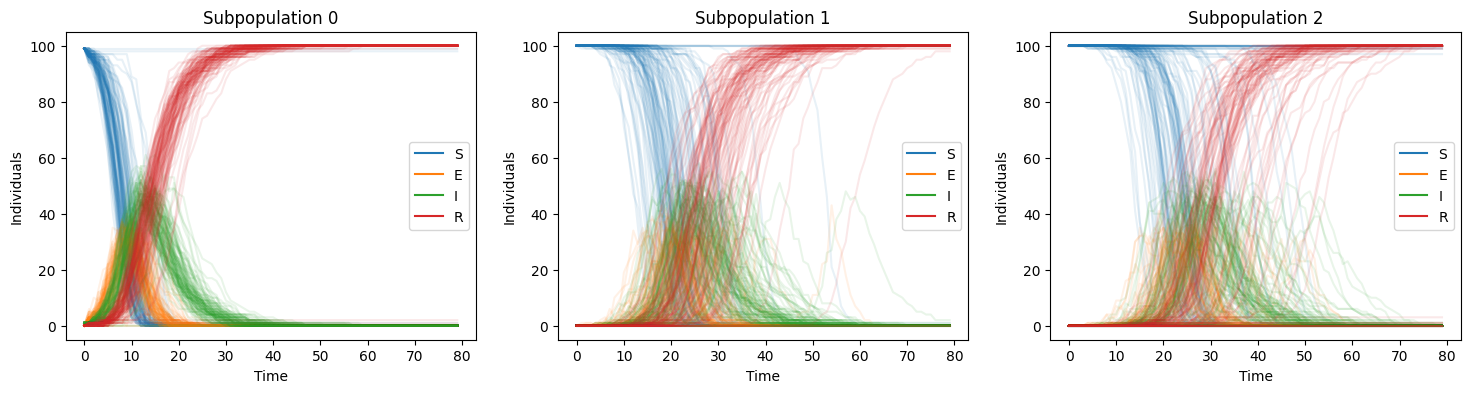

In [ ]:
disc_stoch_states = disc_stoch_model.compute_state(disc_stoch_events)
_ = plot_timeseries(np.arange(80), disc_stoch_states, alpha=0.1)